In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import ipywidgets as widgets
import scipy.integrate as integrate

from ipywidgets import interact, fixed
from scipy.interpolate import interp1d
from textwrap import dedent
from bokeh.io import push_notebook, show, output_notebook, output_file, curdoc
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.themes import built_in_themes
from bokeh.models import Range1d, BasicTickFormatter, Label
from IPython.display import IFrame

# plot bokeh in notebook format
output_notebook()
curdoc().theme = 'dark_minimal'

Loading BokehJS ...

# Inhomogeneous Semiconductors (Chapter 7)

The notebook at hand will lead you through some important concepts about an inhomogeneous semiconductor (pn-junction). The model look at take here is simply the conjunction of two homogeneous semiconductors with a variable doping concentration. The doping concentration is constant at *Nd* for $x<0$, *Na* for $x>0$ and it changes aprubtly at $x=0$.


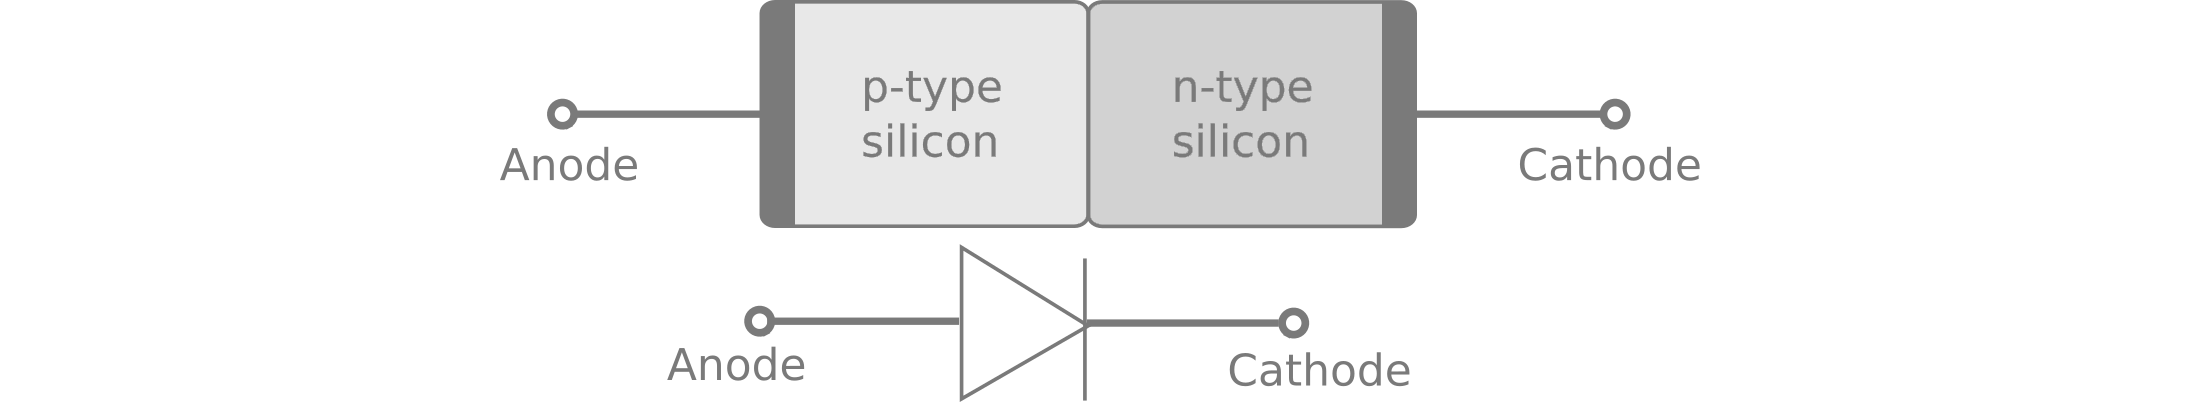

In [2]:
# define constants
kB = 1.380649e-23 # J/K
hbar = 6.626e-34 / (2*np.pi) # J*s
e = 1.60217733e-19 # C
m0 = 9.109383e-31 # kg
T = 300 # K
epsilon0 = 8.854187e-12 # F/m
kBeV = kB/e
Nmin = 1e16; Nmax = 1e18 # cm^-3

# define semiconductor properties
semiconductorList = ['Si', 'Ge','GaAs']
Eg_ = np.array([1.11, 0.66, 1.43]) # Bandgap / eV
me_ = np.array([1.09, 0.55, 0.067]) # average effective electron mass
mh_ = np.array([1.15, 0.37, 0.45]) # average effective hole mass
epsilonR_ = np.array([11.9, 16.2, 13.1]) # relative permittivity

Since there are several parameters associated to a pn junction let us define a *pn object* to pass around all of them in a comprehensible fashion.

In [3]:
class pn(object):
    # The class "constructor" - It's actually an initializer 
    def __init__(self, semiconductor = 'Si'):
        self.semiconductor = semiconductor
        self.nd = 4e17
        self.na = 5e17
    
    # change pn junction type and get associated parameters
    def set_semiconductor(self, semiconductor):
        i = semiconductorList.index(semiconductor)
        self.eg, self.me, self.mh, self.epsilon = Eg_[i], me_[i]*m0, mh_[i]*m0, epsilonR_[i]*epsilon0
        return "Bandgap: {} eV".format(self.eg)
    
    # set p & n doping   
    def set_doping(self, Nd, Na):
        self.nd = Nd
        self.na = Na
        
    # calculate pn-junction properties depending on bandgap and doping
    def get_properties(self):
        self.nc = 1/4* ( 2*self.me*kB*T / (np.pi*hbar**2) )**(3/2) *1e-6 # cm^-3
        self.nv = 1/4* ( 2*self.mh*kB*T / (np.pi*hbar**2) )**(3/2) *1e-6 # cm^-3

        self.ni = (self.nc*self.nv)**(1/2) * np.exp(-self.eg / (2*kBeV*T))

        self.e_Delta_phi = ( self.eg + kBeV*T*np.log(self.nd*self.na / (self.nc*self.nv)) )
        
        # equation for dn, dn length
        def dnp(doping = 'n'):
            if doping == 'n': exponent = 1;
            elif doping == 'p': exponent = -1;
             # factor 1e6 for cm^-3, 1e10 for Angstrom
            return ( (self.na/self.nd)**exponent / ((self.na+self.nd) *1e6) * 2 
                   * self.epsilon * self.e_Delta_phi / e )**(1/2) * 1e10

        self.dn = dnp(doping = 'n')
        self.dp = dnp(doping = 'p')
        return (self.dp, self.dn, self.na, self.nd)

    # print calculated pn-junction properties
    def print_properties(self):
        str ='''
        Intrinsic carrier density: \t {:.1e} cm^-3
        Potential difference: \t\t {:.2f} eV
        Space charge in p, n: \t\t {:.0f} Å, {:.0f} Å
        '''.format(self.ni, self.e_Delta_phi, self.dp, self.dn)
        return print(dedent(str))
    
    # calculate carrier density
    def carrier_density(self, x):
        return np.piecewise(x, [x < -self.dp, ((-self.dp <= x) & (x < 0)), ((0 <= x) & (x <= self.dn)), self.dn < x],
                            [self.na, 0, 0, self.nd])

    # calculate charge density
    def charge_density(self, x):
        return np.piecewise(x, [x < -self.dp, ((-self.dp <= x) & (x < 0)), ((0 <= x) & (x <= self.dn)), self.dn < x],
                            [0, -self.na, self.nd, 0])

    # calculate potential / Ascroft & Mermin p596-597
    def phi1(self, x):
        return (2*np.pi*e * self.na*1e6 / self.epsilon) * (((x + self.dp)/1e10)**2 - (self.dp/1e10)**2)
    def phi2(self, x):
        return (2*np.pi*e * self.nd*1e6 / self.epsilon) * ((self.dn/1e10)**2 - ((x - self.dn)/1e10)**2)
    def potential(self, x):
        return np.piecewise(x, [x < -self.dp, ((-self.dp <= x) & (x < 0)), ((0 <= x) & (x <= self.dn)), self.dn < x],
                            [self.phi1(x = -self.dp), self.phi1, self.phi2, self.phi2(x = self.dn)]) / self.epsilon*epsilon0 # <- why?
    
    # calculate potential with applied voltage / Ascroft & Mermin p598
    def potential_v(self, x, v):
        phi = self.potential(x)
        dPhi = phi[-1]-phi[0]
        a = np.abs(1 - v/dPhi)**(1/2)
        phi = self.potential(x / a)
        phi = phi * (1 - v/dPhi)
        return phi
    
    # calculate current / Ascroft & Mermin p600
    def current(self, v):
        Jsaturation = 1/e # saturation current (random choice)
        j = e * Jsaturation * (np.exp(e*v / (kB*T)) - 1)
        return j

# create pn-junction object
pn1 = pn()
pn1.set_semiconductor(pn1.semiconductor);

Here we define a user interface to chose the semiconductor you would like to work with as well as the doping concentrations *Nd*, *Na*. We will use this shortly.

In [4]:
# get parameters for selected semiconductor
def f(pnx, semiconductor, Nd, Na):
    a = pnx.set_semiconductor(semiconductor)
    pnx.set_doping(Nd,Na)
    
    str ='''
    Bandgap:\t\t\t\t{} eV
    Density of donor impurities: \t\t{:1.1e} cm^-3
    Density of acceptor impurities: \t{:1.1e} cm^-3\
    '''.format(pnx.eg, pnx.nd, pnx.na)
    print(dedent(str))
    return pnx

# create widget object for user interaction
w1 = widgets.Dropdown(description = "Select semiconductor:",
                     options = semiconductorList,
                     style = {'description_width': 'initial'})
kwargs = {'min': np.log10(Nmin), 'max': np.log10(Nmax), 'continuous_update': False,
        'step': .02, 'readout': False, 'style': {'description_width': 'initial'}}
w2 = widgets.FloatLogSlider(description = "$N_d$", value=pn1.nd , **kwargs)
w3 = widgets.FloatLogSlider(description = "$N_a$", value=pn1.na , **kwargs)
ui = widgets.VBox([w1,w2,w3])
out = widgets.interactive_output(f, {'pnx': fixed(pn1), 'semiconductor': w1, 'Nd': w2, 'Na': w3})
# show widget
display(ui, out)

Output()

### Intrinsic carrier density

Recall that the effective density of states is given by the following equation (7.17)

$$
N_{c}(T)=\frac{1}{4}\left(\frac{2 m_{c} k_{B} T}{\pi \hbar^{2}}\right)^{3 / 2} \qquad 
P_{v}(T)=\frac{1}{4}\left(\frac{2 m_{v} k_{B} T}{\pi \hbar^{2}}\right)^{3 / 2}
$$

and we can then deduce the intrinsic carrier density from the _law of mass action_ as (7.19)

$$
n_{i}(T)=[N(T) P(T)]^{1 / 2} \exp \left(-\frac{E_{g}}{2 k_{B} T}\right)
$$

Within our approximation of the charge density being non-zero only inside the depletion region delimited by $d_n$, $d_p$, we found that those widths can be calculated by

$$
d_{n, p}=\left\{\frac{\left(N_{a} / N_{d}\right)^{\pm 1}}{\left(N_{d}+N_{a}\right)} \frac{\epsilon \Delta \phi}{2 \pi e}\right\}^{1 / 2}
$$

In [5]:
# print the calculated properties
pn1.get_properties()
pn1.print_properties()


Intrinsic carrier density: 	 1.4e+10 cm^-3
Potential difference: 		 0.89 eV
Space charge in p, n: 		 323 Å, 404 Å



In [6]:
# define 1D axis along pn-junction
a = 1.5; N = 2**9+ 1
dp, dn, na, nd = pn1.get_properties()
xMax = np.maximum(dn, dp)*a
x = np.linspace(-xMax,xMax, N)

# plot carrier & charge densities, potential
def plot_analytic(pnx, x):
    # create the plots
    kwarsFig = {'plot_width':800, 'plot_height': 200}
    s1 = figure(title = 'Carrier density',y_range=(0, Nmax), **kwarsFig)
    s1.yaxis.axis_label = 'cm^-3'
    s1.yaxis.formatter = BasicTickFormatter(precision = 0)
    kwarsLabel = {'y': 6e17, 'text_font_style': 'bold', 'text_align': 'center', 'text_color': '#226baa'}
    s1.add_layout(Label(text = "p-type", x = -300, **kwarsLabel))
    s1.add_layout(Label(text = "n-type", x = 300, **kwarsLabel))
    r1 = s1.line(x, pnx.carrier_density(x),line_width = 3)
    
    s2 = figure(title = 'Charge density',y_range=(-Nmax, Nmax), **kwarsFig)
    s2.yaxis.formatter = BasicTickFormatter(precision = 0)
    r2 = s2.line(x, pnx.charge_density(x),line_width = 3)
    s2.yaxis.axis_label = 'cm^-3'
    
    s3 = figure(title = 'Potential',y_range=(-1.1, 1.1), **kwarsFig)
    r3 = s3.line(x, pnx.potential(x),line_width = 3)
    s3.xaxis.axis_label = 'x [Å]'
    s3.yaxis.axis_label = 'V'
    
    s = [s1,s2,s3]; r = [r1,r2,r3]
    
    for sx in s:
        sx.x_range = Range1d(-xMax, xMax)
    return s, r
    
def plot_update(pnx, r, x):
    r[0].data_source.data['y'] = pnx.carrier_density(x)
    r[1].data_source.data['y'] = pnx.charge_density(x)
    r[2].data_source.data['y'] = pnx.potential(x)
    push_notebook()
    return

# show plots
s, r = plot_analytic(pn1, x)
show(column(s), notebook_handle=True);
plot_update(pn1, r,x)

In the above plots we see that the carrier density is essentially zero in the depletion region ($-d_p<x<d_n$) since those carriers diffused into the other region to form free charges. While doing so they build up a potential that then induceds a drift current in the oposite direction. The densities we see here are found when the equilibrium between the diffusion and drift current established and they therefore cancel each other out. Now, what happens when we adjust the doping concentrations on either side?

In [7]:
# define 1D axis along pn-junction
N = 2**9+ 1
dp, dn, na, nd = pn1.get_properties()
xMax = 1500
x = np.linspace(-xMax,xMax, N)

# show plots
s, r= plot_analytic(pn1, x)
show(column(s), notebook_handle=True)
plot_update(pn1, r, x)

# now let us change this diagramm interactively
def f2(semiconductor, Nd, Na, pnx = pn1, x = x, r = r):
    f(pnx, semiconductor, Nd, Na)
    pnx.get_properties()
    plot_update(pnx, r, x)

out = widgets.interactive_output(f2,  {'semiconductor': w1, 'Nd': w2, 'Na': w3})
display(ui, out)

Output()

Here you have the unique chance of continuously adjusting your pn-junction (iterating samples in the cleanroom takes a lot longer :P). Now what can do we see here?
* One thing to notice is that the area underneath the charge density in $x<0$ equals $x>0$ corresponding to the fact that the charge difference is the same. 

In [11]:
x = np.array([-146.  , -136.  , -126.  , -116.  , -106.  ,  -96.  ,  -86.  ,
         -76.  ,  -66.  ,  -58.  ,  -53.  ,  -48.  ,  -43.  ,  -38.  ,
         -33.  ,  -28.  ,  -23.  ,  -19.  ,  -16.5 ,  -14.  ,  -11.5 ,
          -9.  ,   -6.5 ,   -4.  ,   -1.5 ,    0.75,    3.25,    5.75,
           8.25,   10.75,   13.25,   15.75,   18.25,   21.5 ,   26.5 ,
          31.5 ,   36.5 ,   41.5 ,   46.5 ,   51.5 ,   56.5 ,   63.  ,
          73.  ,   83.  ,   93.  ,  103.  ,  113.  ,  123.  ,  133.  ,
         143.  ])
spaceCharge=np.array([-1.04647e-04, -2.16539e-04, -5.81861e-04, -1.62462e-03,
        -4.53152e-03, -1.24302e-02, -3.25418e-02, -7.58595e-02,
        -1.39543e-01, -1.79867e-01, -1.92558e-01, -1.97879e-01,
        -1.99537e-01, -1.99923e-01, -1.99990e-01, -1.99999e-01,
        -2.00000e-01, -2.00000e-01, -2.00000e-01, -2.00000e-01,
        -2.00000e-01, -2.00000e-01, -2.00000e-01, -2.00000e-01,
        -2.00000e-01,  3.00000e-01,  3.00000e-01,  3.00000e-01,
         3.00000e-01,  2.99999e-01,  2.99996e-01,  2.99985e-01,
         2.99944e-01,  2.99741e-01,  2.98016e-01,  2.89897e-01,
         2.65645e-01,  2.19665e-01,  1.61602e-01,  1.07818e-01,
         6.72400e-02,  3.42751e-02,  1.14088e-02,  3.68516e-03,
         1.17887e-03,  3.75955e-04,  1.19799e-04,  3.82260e-05,
         1.23965e-05,  4.64809e-06])
potential=np.array([-0.78429, -0.78428, -0.78423, -0.7841 , -0.78371, -0.78264,
        -0.77969, -0.77191, -0.75325, -0.72478, -0.69904, -0.66659,
        -0.62722, -0.58087, -0.52753, -0.46719, -0.39986, -0.34095,
        -0.30186, -0.26102, -0.21844, -0.1741 , -0.12801, -0.08017,
        -0.03059,  0.01534,  0.06475,  0.11154,  0.1557 ,  0.19724,
         0.23616,  0.27245,  0.30611,  0.34596,  0.39861,  0.44086,
         0.47301,  0.49593,  0.5112 ,  0.52081,  0.5266 ,  0.5307 ,
         0.53331,  0.53415,  0.53442,  0.53451,  0.53453,  0.53454,
         0.53455,  0.53455])

# data from pn-junction simulation nextnano
# https://www.nextnano.com/nextnano3/tutorial/1Dtutorial_pn_junction.htm

# convert units from numerical simulation
x_num = x*10 # Angstrom
spaceCharge = spaceCharge*1e18 # cm^-3
potential = potential # V

# smooth out sampled data
def spaceCharge_interpolated(x, x_num = x_num, spaceCharge = spaceCharge):
    return np.piecewise(x, [x < 0, x >= 0], [interp1d(x_num[x_num<0],spaceCharge[x_num<0],kind='cubic',fill_value="extrapolate"),
                interp1d(x_num[x_num>=0],spaceCharge[x_num>=0],kind='cubic',fill_value="extrapolate")])

potential_interpolated = interp1d(x_num,potential,kind='cubic',fill_value="extrapolate")

x = np.linspace(x_num[0],x_num[-1],300)

# define semiconductor for comparison
pn2 = pn()
pn2.set_semiconductor('GaAs')
pn2.set_doping(Na = 0.2e18, Nd = 0.3e18)
dp, dn, na, nd = pn2.get_properties()

# plot figures
kwars = {'plot_width':800, 'plot_height': 300}
s1 = figure(title = 'Charge density', **kwars)
s1.yaxis.axis_label = 'cm^-3'
s1.yaxis.formatter = BasicTickFormatter(precision = 0)
s1.add_layout(Label(text = "p-type", x=-dp/2, text_align = 'center', text_color = '#4f86f7'))
s1.add_layout(Label(text = "n-type", x=dn/2, text_align = 'center', text_color = '#4f86f7'))
r1 = s1.line(x,spaceCharge_interpolated(x), legend_label='numerical solution', line_width = 3, line_color="orange")
r12 = s1.line(x, pn2.charge_density(x), legend_label='analytical approximation', line_width = 3)

s2 = figure(title = 'Potential', **kwars)
s2.yaxis.axis_label = 'V'
r2 = s2.line(x, potential_interpolated(x), legend_label='numerical solution', line_width = 3, line_color="orange")
r22 = s2.line(x, pn2.potential(x), legend_label='analytical approximation', line_width = 3)
s2.xaxis.axis_label = 'x [Å]'

show(column([s1,s2]));

As mentioned in the beginning we here look at the analytical approximation made in the lecture. Recall that this approximation consist of treating the charge density as being non-zero only within the depletion region. But how accurate is this approximation?

Let us say we want to treat a more rigurous model of the pn-junction, so we are left to solve the equilibrium between the drift and diffusion current involving the poisson equation for the potential (which is generating the diffusion current). Were thus left to solve a set of coupled non-linear differential equations so we might not be able to solve them analytically but we can do it numerivally. In fact there are numerous tools at hand for doing this. Above we see such a solution for a certain choice of semiconductor, doping concentrations, temperature...

What is important to note is that even though there are some deviations of the charge density at the edge of the depletion region the potentials from both methods coincide with little error.

In [9]:
# define semiconductor for comparison
pn3 = pn()
pn3.set_semiconductor('GaAs')
pn3.set_doping(Na = 0.2e18, Nd = 0.3e18)
dp, dn, na, nd = pn3.get_properties()

# define 1D axis along pn-junction
a = 1.5; N = 2**9+ 1
dp, dn, na, nd = pn1.get_properties()
xMax = np.maximum(dn, dp)*a
x = np.linspace(-xMax,xMax, N)
v = np.linspace(-1,.2, 100)
Irange = [-1.5, 25]

# plot carrier & charge densities, potential
def plot_analytic(pnx, x):
    # create the plots
    kwarsFig = {'plot_width':500, 'plot_height': 500}
    s1 = figure(title = 'Potential',y_range=(-1.1, 1.1), **kwarsFig)
    s1.xaxis.axis_label = 'x [Å]'
    s1.yaxis.axis_label = 'V'
    kwarsLabel = {'y': 6e17, 'text_font_style': 'bold', 'text_align': 'center', 'text_color': '#226baa'}
    s1.add_layout(Label(text = "p-type", x = -300, **kwarsLabel))
    s1.add_layout(Label(text = "n-type", x = 300, **kwarsLabel))
    s1.x_range = Range1d(-xMax, xMax)
    r1 = s1.line(x, pnx.potential(x),line_width = 3)
    r12 = s1.line(x, pnx.potential(x))
    
    s2 = figure(title = 'I vs. V', **kwarsFig)
    s2.yaxis.formatter = BasicTickFormatter(precision = 3)
    r2 = s2.line(v, pnx.current(v), line_width = 3)
    r22 = s2.line([0,0], Irange, line_color = 'red')
    s2.x_range = Range1d(v[0], v[-1])
    s2.y_range = Range1d(Irange[0],Irange[1])
    s2.yaxis.axis_label = 'I [a.u.]'
    s2.xaxis.axis_label = 'V'
    
    s = [s1,s2]; r = [r1,r2,r22]
    return s, r

# show plots
s, r = plot_analytic(pn1, x)
show(row(s), notebook_handle=True);
    
def plot_update(pnx, v_applied, r = r, x = x, v = v):
    r[0].data_source.data['y'] = pnx.potential_v(x, v_applied)
    r[1].data_source.data['y'] = pnx.current(v)
    r[2].data_source.data['x'] = [v_applied,v_applied]
    r[2].data_source.data['y'] = Irange
    push_notebook()
    return

# get parameters for selected semiconductor
def f3(pnx, v_applied, r = r, x = x):
    plot_update(pnx, v_applied = v_applied)
    print("Current: {:.1e} a.u.".format(pnx.current(v_applied)))
    return pnx

# create widget object for user interaction
kwargs = {'min': -1, 'max': 1.2, 'continuous_update': True,
        'step': .01, 'style': {'description_width': 'initial'}}
w1 = widgets.FloatSlider(description = "$V$", value=0 , **kwargs)
ui = widgets.VBox([w1])
out = widgets.interactive_output(f3, {'pnx': fixed(pn1), 'v_applied': w1})

display(ui, out)

Output()

Now we adjust the voltage that is applied to the pn-junction (in forward direction). In the above plots we see on the right side again the potential along the axis of the junction and on the left side its I-V characteristic.
We can remark the following points:
* Without any externally applied voltage (V = 0) the potential is unaltered from what we calculatd above.
* When we increase the voltage the potential barrier from the p to the n side decreases linearely until $\Delta\Phi$ is reached and the potential is esentially zero along the pn-junction (in this case $\Delta\Phi = 0.94 V$). Further increase of the applied voltage reverses the potential from a barrier to a slope.
* Furthermore the width of the depletion region changes with the applied voltage. Remark that the width of the width gets larger when we reverse bias the junction and therefore decreases the chance of tunneling charge carriers through the barrier.
* The I-V curve shows the exponential growth of the current with the applied voltage. Notice that in the reverse bias setting there is a residual current which corresponds to the generated carriers $e(J^{gen}_h + J^{gen}_e)$. Note that the generation current has different contributions like Shockley-Read-Hall or Auger generation and has been chosen arbitrarily here.

Many thanks for going through this notebook. :)<br>
Please forward any comments, suggestions or thank-you notes below and have a nice day!

In [10]:
IFrame("https://docs.google.com/forms/d/e/1FAIpQLSeiQNlfS9Hm2UwlaxzfEdssZ57LS-sXb6XkDOBHiqHis-vs4A/viewform?embedded=true", 600, 621)